In [1]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import matplotlib.dates as mdates
import datetime
import matplotlib
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader, RinexReader

# Prepare the data

In [2]:
# Load log files
measurements_log = ['Raw', 'Fix']
#measurements_RINEX = ['C1C']
measurements_RINEX = sum([[f"{y}{x}" for y in ['C', 'L', 'D', 'S']] for x in ['1C', '5Q', '2I', '5P']], [])
logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixel7_20230217095501.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixelWatch_20230814145154_modified.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20232260000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_OnePlusNord2_20230303105504.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_SamsungA52_20230317141230.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230760000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_Xiaomi11_20230303095606.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

device_list = [log.device for log in logs]

In [3]:
log.ref.df

,time,sv,signal,doppler,phase,pseudorange,snr,prn,system,frequency,pseudorange_rate,pseudorange_error,phase_rate,phase_error,doppler_error
0,2023-03-03 07:56:30,C02,2I,13.049,2.153751e+08,4.136055e+07,31.985,C02-L1,C,L1,NaN,NaN,NaN,NaN,NaN
1,2023-03-03 07:56:30,C05,2I,7.681,2.086563e+08,4.007023e+07,34.976,C05-L1,C,L1,NaN,NaN,NaN,NaN,NaN
2,2023-03-03 07:56:30,C07,2I,-704.308,1.987208e+08,3.816225e+07,40.677,C07-L1,C,L1,NaN,NaN,NaN,NaN,NaN
3,2023-03-03 07:56:30,C10,2I,-302.389,1.957743e+08,3.759639e+07,42.171,C10-L1,C,L1,NaN,NaN,NaN,NaN,NaN
4,2023-03-03 07:56:30,C14,2I,-1587.544,1.208079e+08,2.319988e+07,44.539,C14-L1,C,L1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,2023-03-03 08:41:00,S23,1C,3.757,2.070533e+08,3.940086e+07,41.149,S23-L1,S,L1,-0.476367,0.005614,-2.777400,0.004833,0.016900
6656,2023-03-03 08:41:00,S28,1C,-5.331,2.151742e+08,4.094632e+07,31.275,S28-L1,S,L1,1.125967,-0.000292,6.639833,0.003604,0.034900
6657,2023-03-03 08:41:00,S36,1C,4.909,2.078706e+08,3.955646e+07,37.051,S36-L1,S,L1,-0.617967,0.009908,-3.588667,-0.006822,0.036400
6658,2023-03-03 08:41:00,S44,1C,76.644,2.143480e+08,4.078907e+07,37.732,S44-L1,S,L1,-14.378500,0.004248,-75.736967,0.004483,0.012267


In [4]:
log.raw.loc[log.raw['prn'].isin(['G30-L1']), ['TimeNanos', 'AccumulatedDeltaRangeMeters', 'PhaseVelocity', 'PhaseError']]


,TimeNanos,AccumulatedDeltaRangeMeters,PhaseVelocity,PhaseError
datetime,,,,
2023-03-03 07:56:12,1.109580e+11,1.157872e+04,NaN,NaN
2023-03-03 07:56:13,1.119580e+11,1.320560e+04,1626.885318,NaN
2023-03-03 07:56:20,1.189580e+11,2.457599e+04,1624.341470,-0.363407
2023-03-03 07:56:28,1.269580e+11,3.756800e+04,1624.000660,-0.042601
2023-03-03 07:56:29,1.279580e+11,3.919295e+04,1624.956413,0.955753
...,...,...,...,...
2023-03-03 08:28:21,2.039966e+12,2.701679e+06,1874.120283,-0.695105
2023-03-03 08:28:23,2.041966e+12,2.705428e+06,1874.254097,0.066907
2023-03-03 08:28:30,2.048966e+12,2.388159e+06,-45324.048717,-6742.614688


In [5]:
# only keep GPS provider
log.fix = log.fix.loc[log.fix["provider"] == 'GPS']

In [6]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.diff = log.fix[["east", "north", "up"]].copy()
    
    log.diff[["2D_error"]] = log.diff.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.diff[["3D_error"]] = log.diff.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

    print(f"--- {log.device} ---")
    print(log.diff.describe())

--- Pixel 7 ---
              east        north           up     2D_error     3D_error
count  3169.000000  3169.000000  3169.000000  3169.000000  3169.000000
mean    -12.000680    -0.806966     2.530620    13.310786    14.515084
std      35.299592    11.865637     1.311160    36.801287    36.454612
min    -167.507519   -74.833770    -0.945141     0.499089     1.167275
25%      -2.416438     0.653036     1.548997     1.364514     2.441068
50%      -1.386920     1.092363     2.888991     1.848141     3.384709
75%      -0.924462     1.655990     3.287500     3.409349     4.745906
max     124.580622    68.533222    20.487416   167.648560   167.651464
--- Pixel Watch ---
              east        north           up     2D_error     3D_error
count  1107.000000  1107.000000  1107.000000  1107.000000  1107.000000
mean      0.513459    -1.395790     1.020882     2.260069     3.069734
std       0.839207     1.614166     2.117235     0.641201     1.271891
min      -0.722799    -3.226171    -3.391

# Results

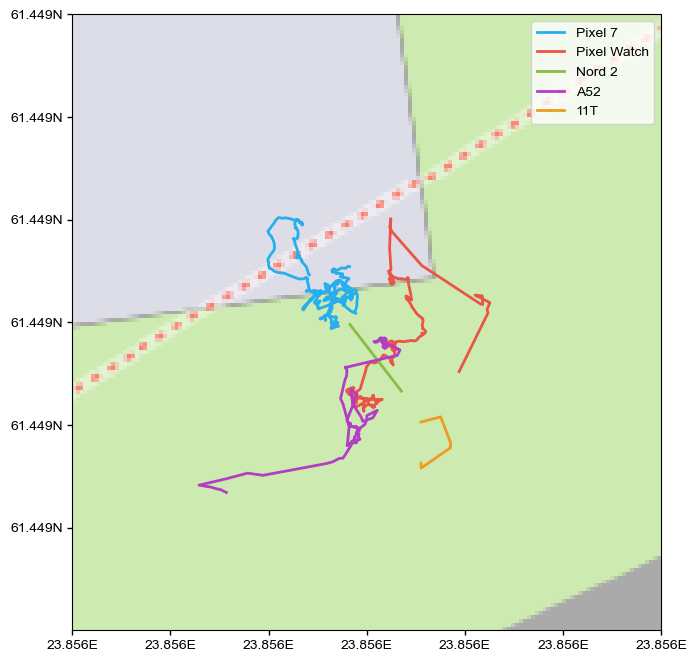

In [7]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

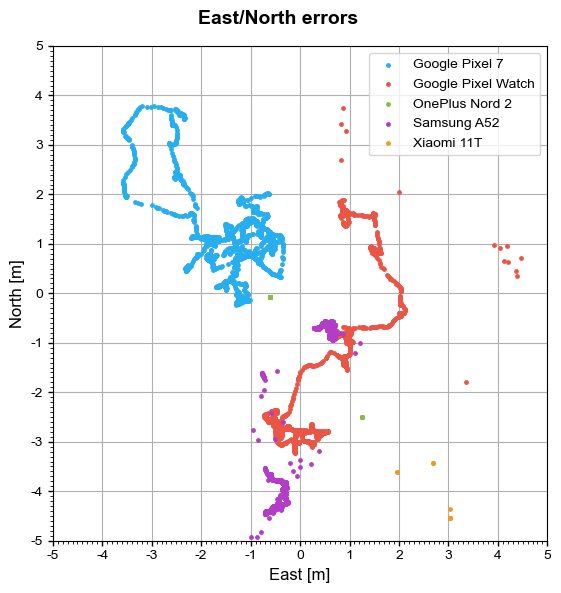

In [8]:
plotEN(logs, lim=5, ticks=[0.1, 1])

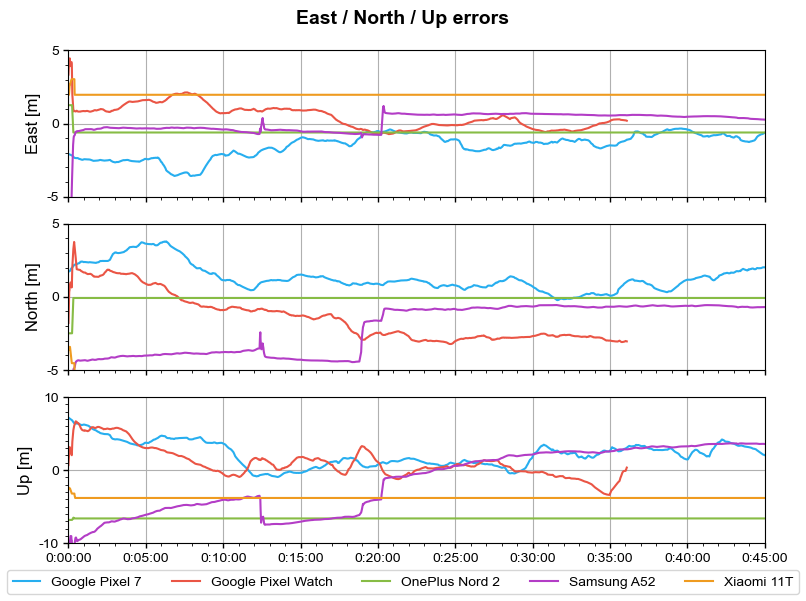

In [9]:
plotENU(logs, lim=[5,5,10], ticks=[1, 5, 1, 5, 1, 10])

### Visibility

In [34]:
def plotTotalSignalsPerEpochs(logs, lim, ticks, mode='signal'):

    minor_ticks = ticks[0]
    major_ticks = ticks[1]

    if mode == 'signal':
        column = 'prn'
    elif mode == 'satellite':
        column = 'sv'

    fig, axs = plt.subplots(1, figsize=(6,5))
    fig.suptitle(f"Total {mode}s seen per epoch")

    for log in logs:

        df = log.raw[['TimeNanos', column]]
        df = df.groupby('TimeNanos').nunique()
        #df.plot(y='prn', label=log.device, style='o', ms=2, ax=axs)
        time = np.array(df.index.tolist()) * 1e-9
        axs.scatter(time - time[0], df[column].tolist(), label=f"{log.manufacturer} {log.device}", marker='.')

    axs.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    axs.xaxis.set_major_locator(MultipleLocator(major_ticks))
    def timeTicks(x, pos):                                                                                                                                                                                                                                                         
        d = datetime.timedelta(seconds=x)                                                                                                                                                                                                                                          
        return str(d)                                                                                                                                                                                                                                                              
    formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
    axs.xaxis.set_major_formatter(formatter)
    axs.set_axisbelow(True)
    axs.legend()
    axs.set_ylim(lim[0], lim[1])
    fig.tight_layout()

    #axs.margins(x=0)


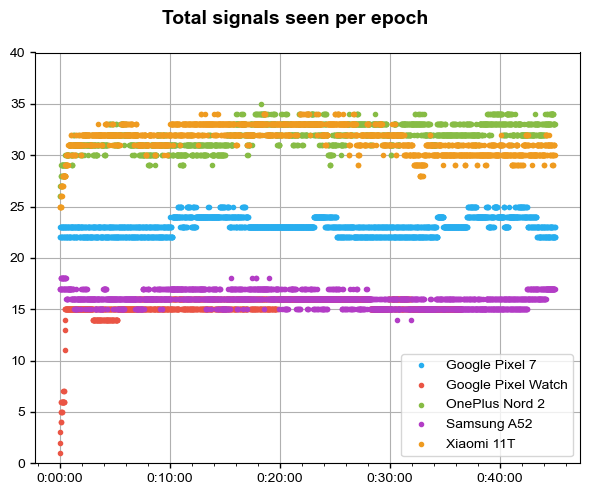

In [35]:
plotTotalSignalsPerEpochs(logs, lim=[0, 40], ticks=[120, 600], mode='signal')

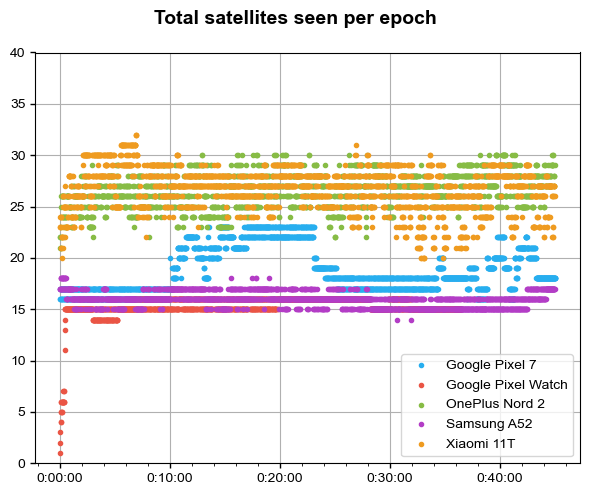

In [36]:
plotTotalSignalsPerEpochs(logs, lim=[0,40], ticks=[120, 600], mode='satellite')

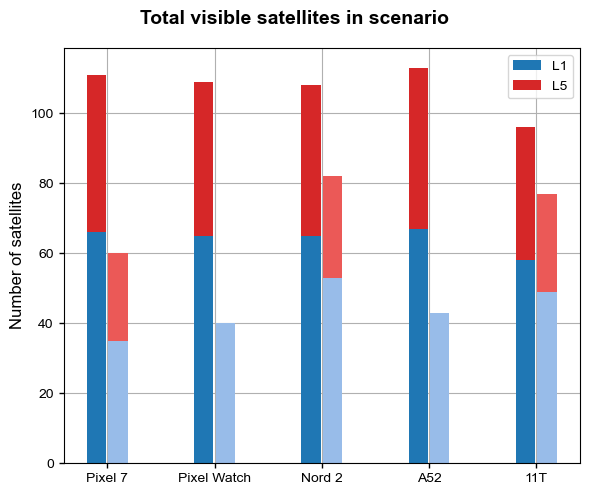

In [11]:
plotTotalSatellitesBar(logs, normalised=False)

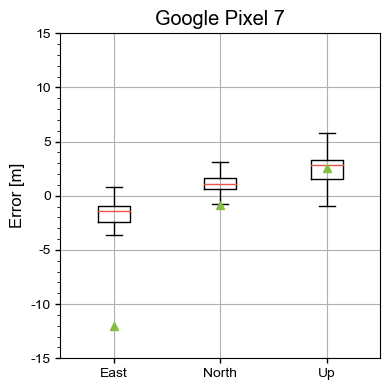

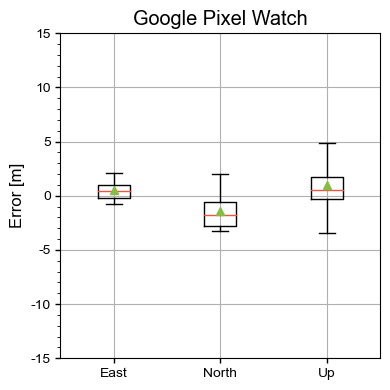

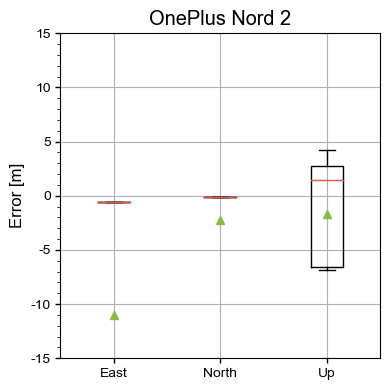

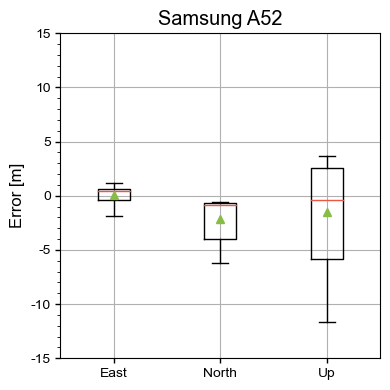

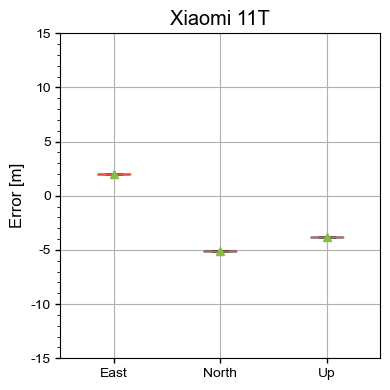

In [12]:
plotStatisticsENU(logs, lim=15, ticks=[1, 5], mode='box')

### Measurements

Pseudoranges

Rows removed 60 (0.100%)
Rows removed 22 (0.069%)
Rows removed 0 (0.000%)
Rows removed 8 (0.019%)
Rows removed 32 (0.039%)


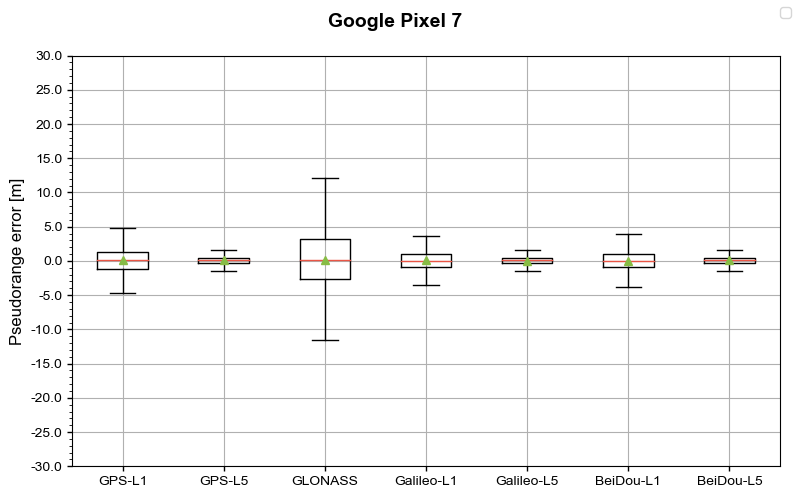

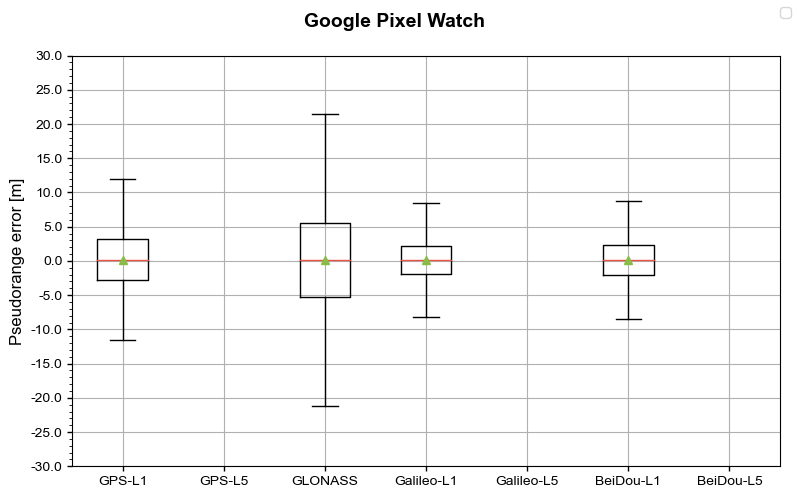

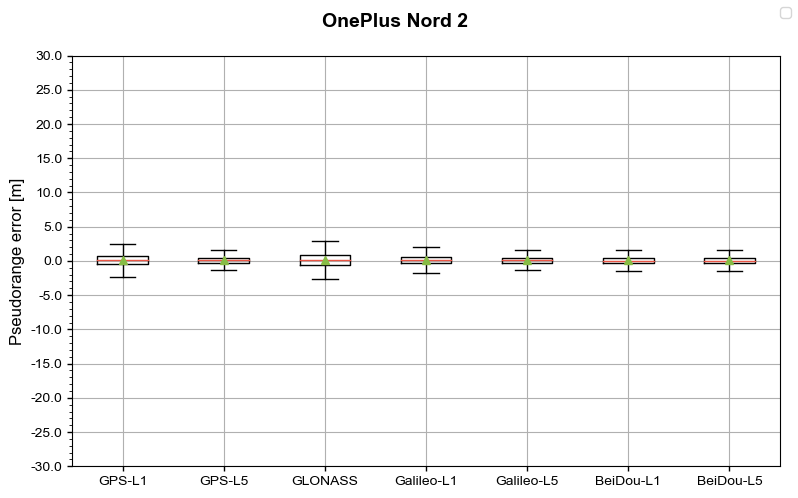

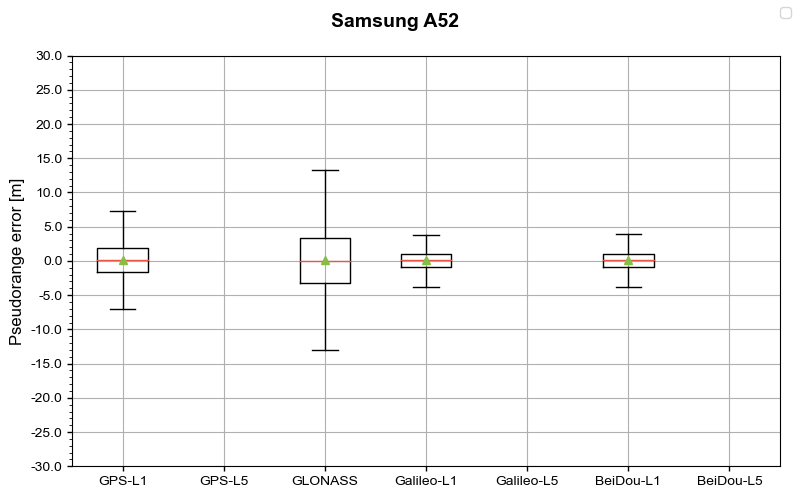

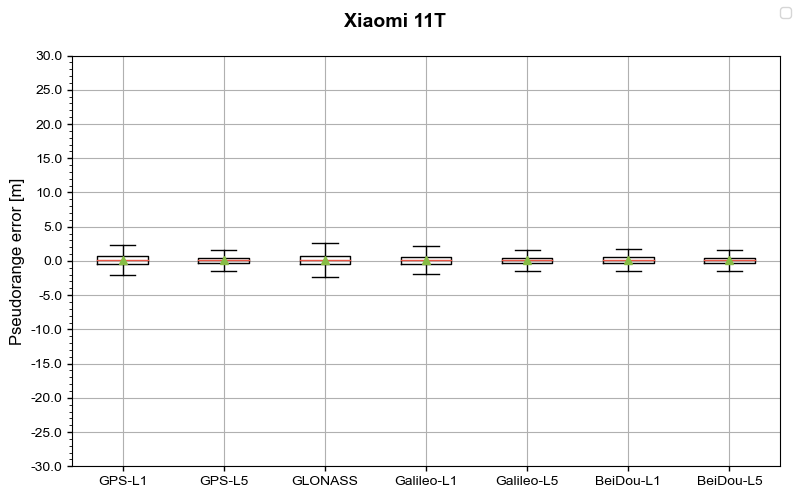

In [13]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])

--- Pixel 7 ---
Rows removed 0 (0.000%)
--- Pixel Watch ---
Rows removed 0 (0.000%)
--- Nord 2 ---
Rows removed 0 (0.000%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 0 (0.000%)
           Pixel 7  Pixel Watch       Nord 2          A52          11T
count  7422.000000  5515.000000  6830.000000  7656.000000  6501.000000
mean      0.063235     0.060197     0.062713     0.075177     0.066539
std       1.808790     0.470781     1.610248     1.728020     0.504492
min    -108.756947   -16.098876   -50.681906   -72.456436   -23.339063
50%       0.061136     0.053696     0.051206     0.064310     0.066000
66.7%     0.080634     0.079016     0.077096     0.085005     0.084022
95%       0.133907     0.135070     0.139426     0.129604     0.131262
99.7%     0.174760     0.174711     0.180594     0.170983     0.177369
max     108.773149    22.944831    50.698849    87.806397    23.510598


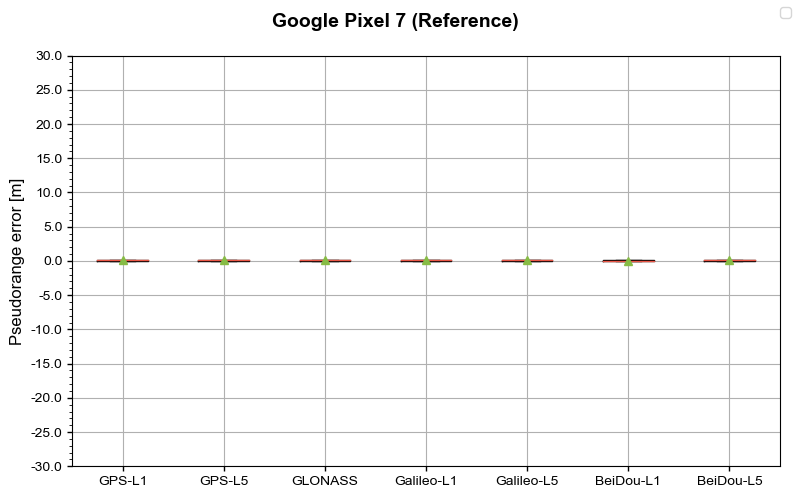

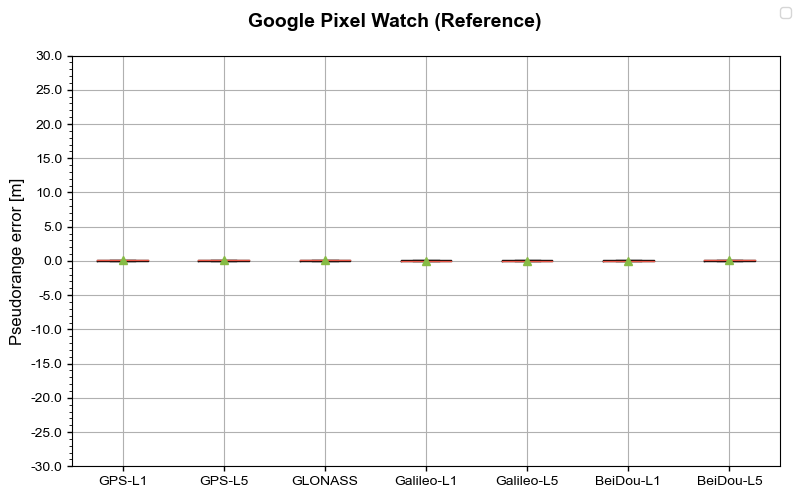

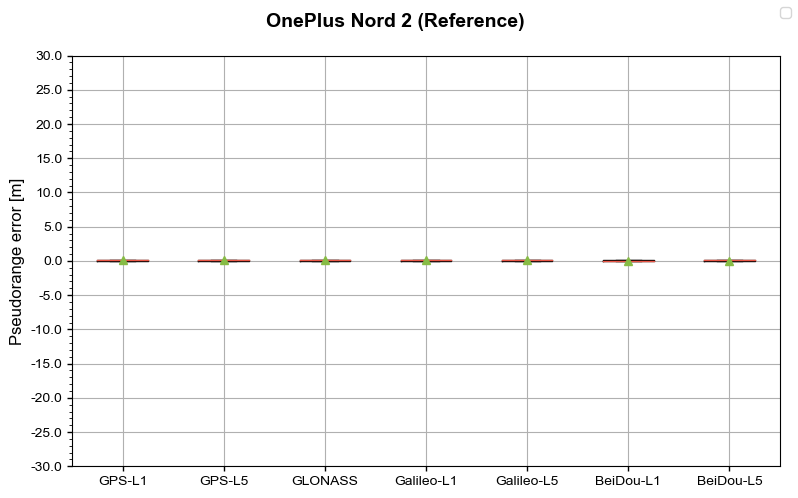

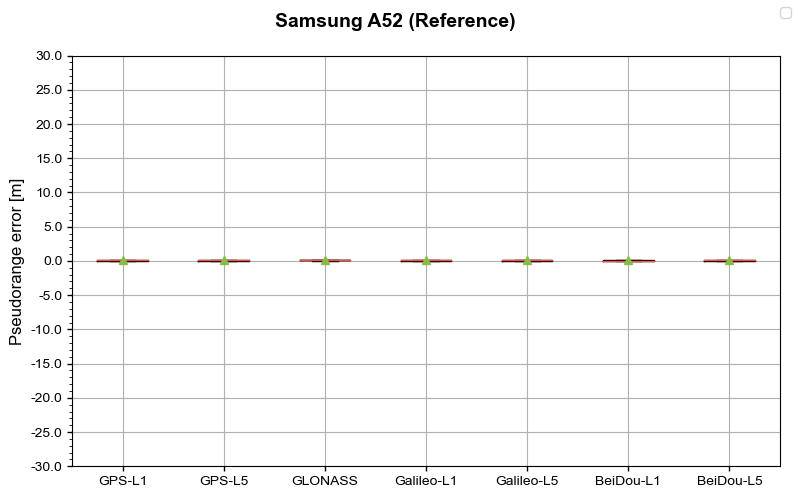

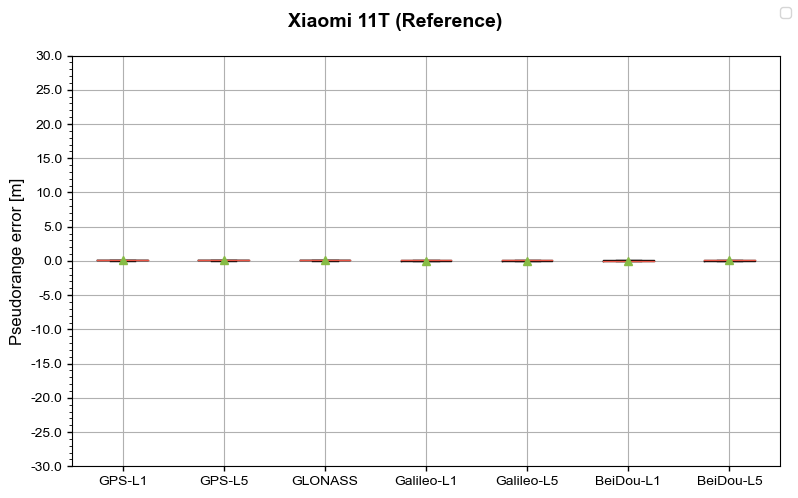

In [14]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'pseudorange_error', 300)
    stats.append(log.ref.df['pseudorange_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'pseudorange_error', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5],
                      mode='ref')


In [17]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssState_Str.values())].count()
    df = log.raw[list(misc.GnssState_Str.values())].sum().div(count).mul(100).transpose()
    print(df)

--- Pixel 7 ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                71.761994
TRACK_BIT_SYNC                 77.494437
TRACK_SUBFRAME_SYNC            49.214811
TRACK_TOW_DECODED              34.242584
TRACK_MSEC_AMBIGUOUS            0.000000
TRACK_SYMBOL_SYNC              77.499240
TRACK_GLO_STRING_SYNC           2.788583
TRACK_GLO_TOD_DECODED           2.566073
TRACK_BDS_D2_BIT_SYNC           0.000000
TRACK_BDS_D2_SUBFRAME_SYNC      0.000000
TRACK_GAL_E1BC_CODE_LOCK       14.997839
TRACK_GAL_E1C_2ND_CODE_LOCK    27.040612
TRACK_GAL_E1B_PAGE_SYNC         0.000000
TRACK_SBAS_SYNC                 0.000000
TRACK_TOW_KNOWN                95.761098
TRACK_GLO_TOD_KNOWN             4.238902
TRACK_S_2ND_CODE_LOCK          68.813331
dtype: float64
--- Pixel Watch ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                67.650045
TRACK_BIT_SYNC                 89.949239
TRACK_SUBFRAME_SYNC            42.708271
TRACK_TOW_DECODED              47.885936
TRACK_

Doppler

Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)


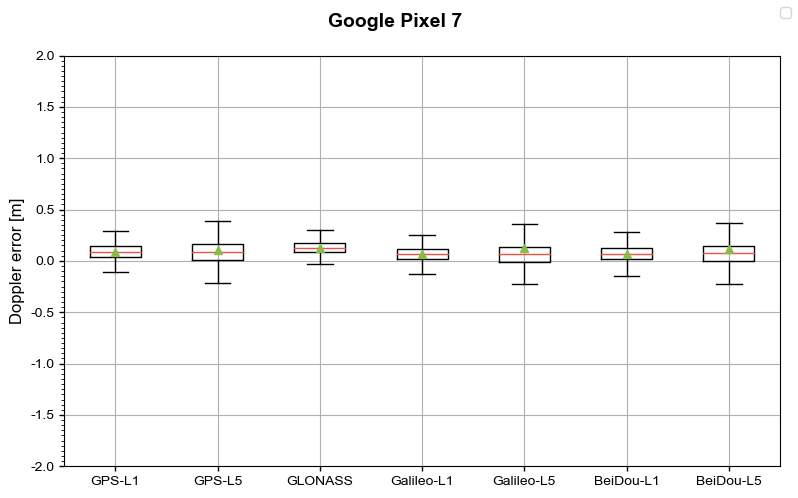

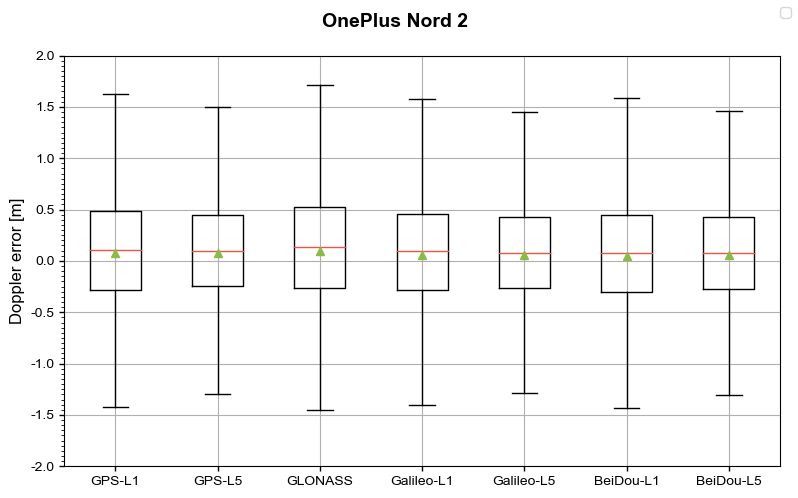

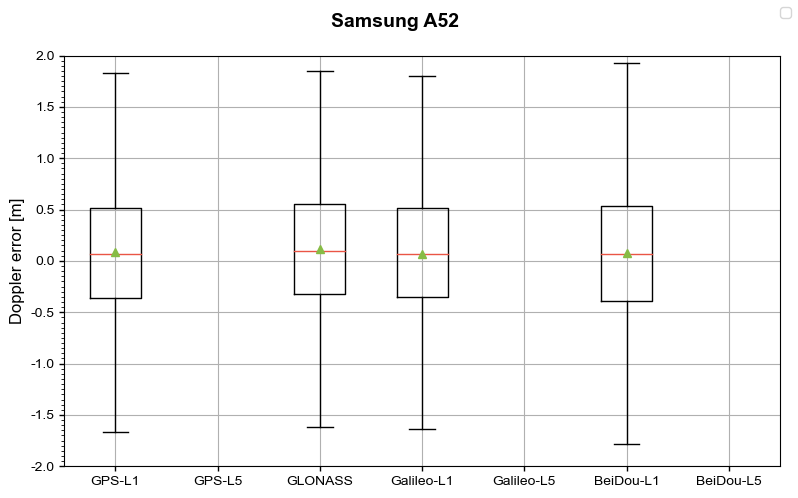

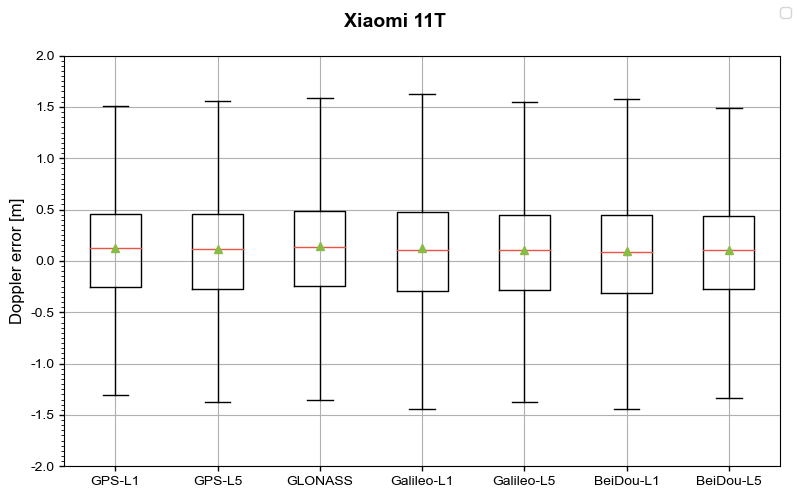

In [ ]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'DopplerError', 300)
plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])

In [ ]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'doppler_error', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.ref.df['doppler_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'doppler_error', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=4,
                      ticks=[0.05,0.5],
                      mode='ref')

Phases

--- Pixel 7 ---
Rows removed 449 (0.719%)
count    62020.000000
mean         0.089458
std          0.575235
min        -20.030491
50%          0.073663
66.7%        0.106081
95%          0.321502
99.7%        2.516578
max         21.324966
Name: PhaseError, dtype: float64
--- Nord 2 ---
Rows removed 773 (0.896%)
count    85454.000000
mean         0.141978
std          4.696983
min       -186.762104
50%          0.087092
66.7%        0.284372
95%          1.189747
99.7%       12.475090
max        184.906967
Name: PhaseError, dtype: float64
--- A52 ---
Rows removed 43026 (100.000%)
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
66.7%    NaN
95%      NaN
99.7%    NaN
max      NaN
Name: PhaseError, dtype: float64
--- 11T ---
Rows removed 673 (0.789%)
count    84577.000000
mean         0.140526
std          0.982511
min        -12.564804
50%          0.127054
66.7%        0.302992
95%          1.509314
99.7%        5.236262
max         12.634293
Name: PhaseError, dtype: fl

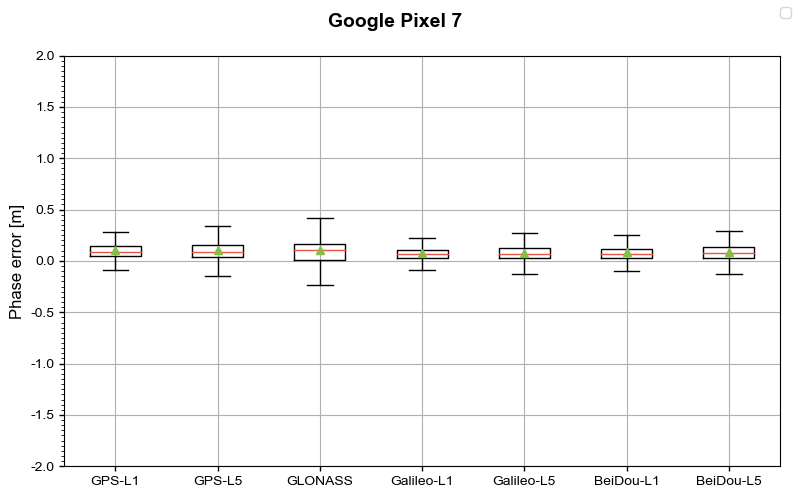

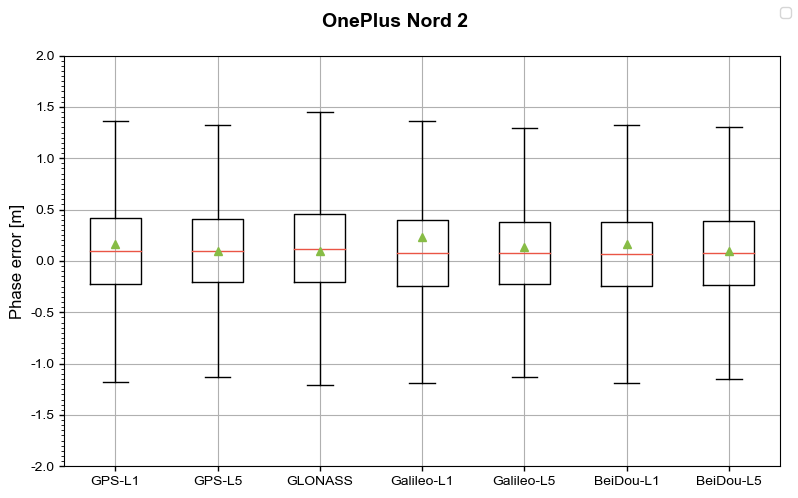

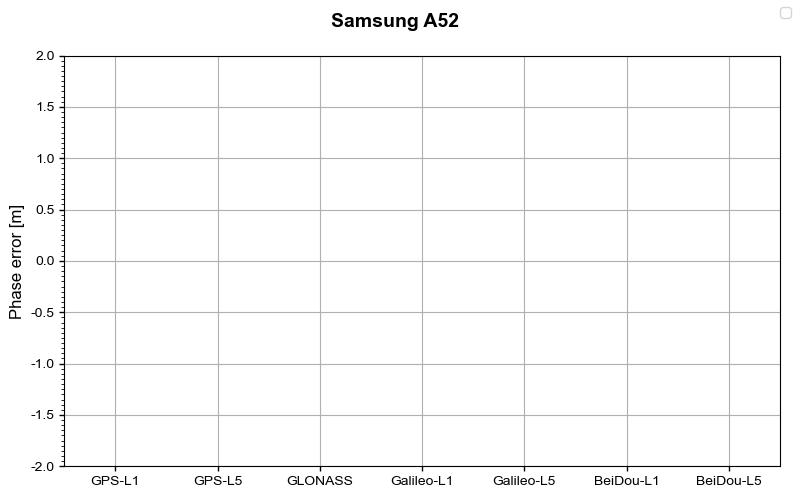

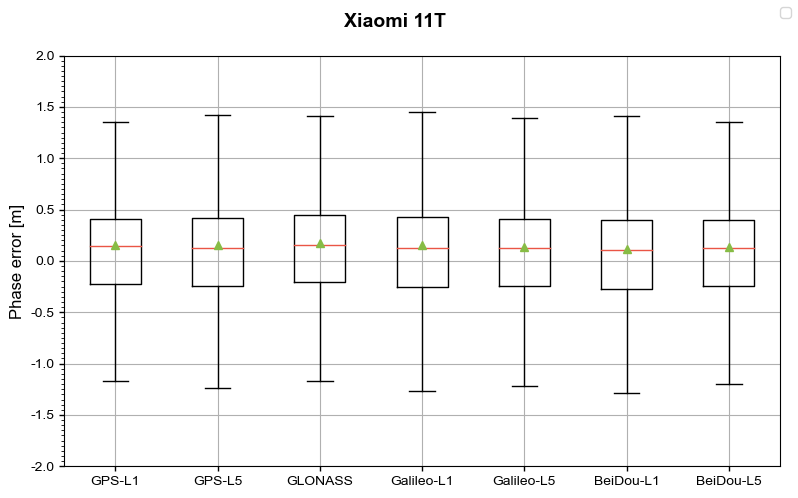

In [ ]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    print(log.raw['PhaseError'].describe(percentiles=[0.5, .667, .95, .997]).T)
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])
    

In [ ]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'phase_error', 500)
    stats.append(log.ref.df['phase_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))
plotStatisticsDataBox(_logs, 
                      'phase_error', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      mode='ref')

In [ ]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')


In [ ]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    print(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count).mul(100))

--- Pixel 7 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   76.770878
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               0.566681
ADR_HALF_CYCLE_RESOLVED     72.644031
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Nord 2 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   82.392986
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               7.858327
ADR_HALF_CYCLE_RESOLVED     77.790019
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- A52 ---
ADR_UNKNOWN                  0.0
ADR_VALID                    0.0
ADR_RESET                    0.0
ADR_CYCLE_SLIP               0.0
ADR_HALF_CYCLE_RESOLVED      0.0
ADR_HALF_CYCLE_REPORTED    100.0
dtype: float64
--- 11T ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   89.468622
ADR_RESET                    0.000000
ADR_CYCLE_SLIP              15.298534
ADR_HALF_CYCLE_RESOLVED     81.528446
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64


### C/N0

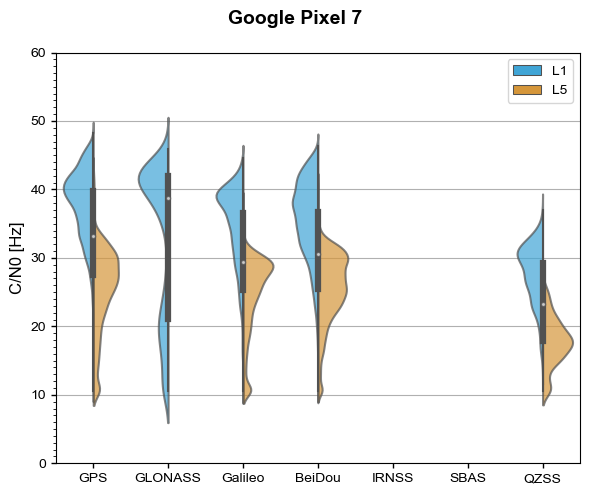

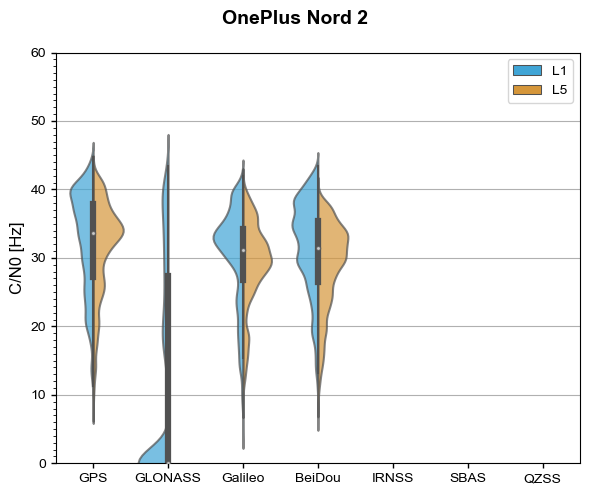

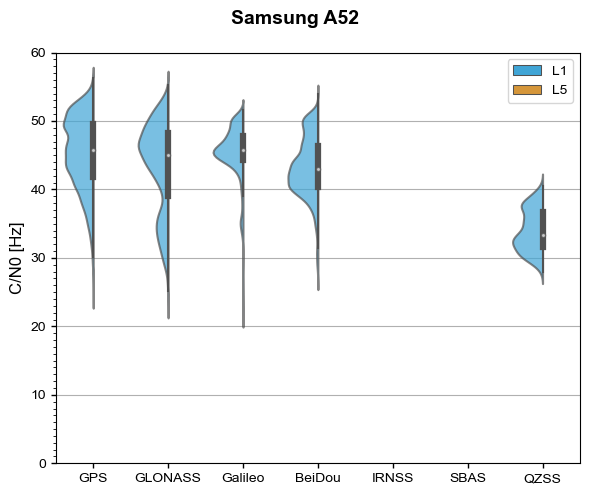

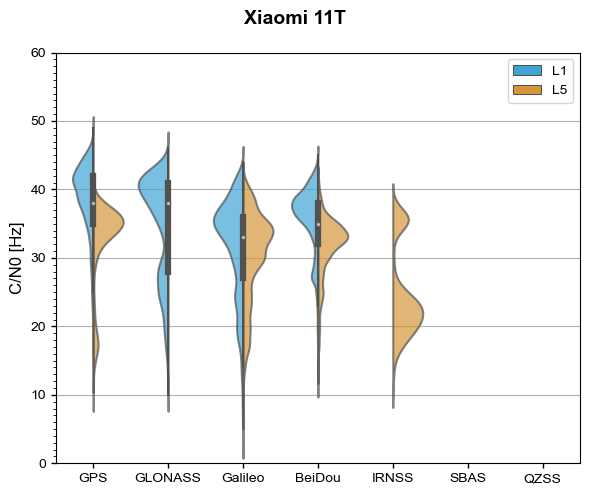

In [ ]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10])

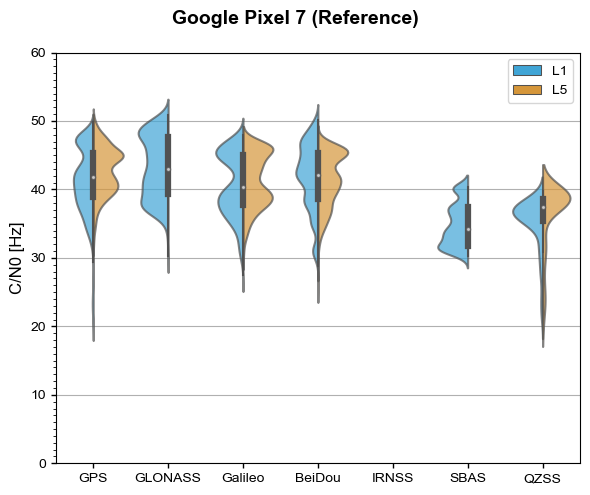

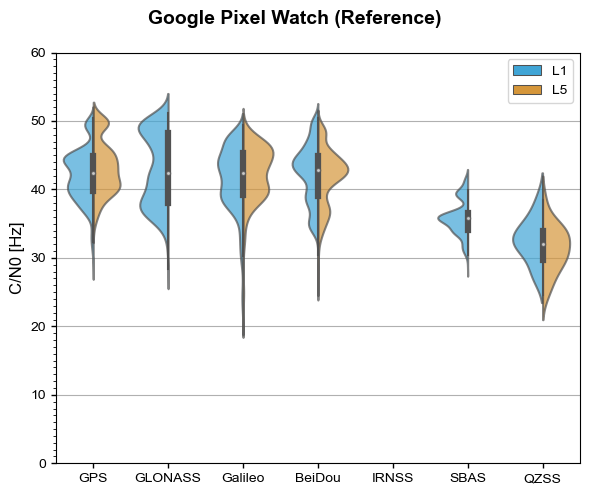

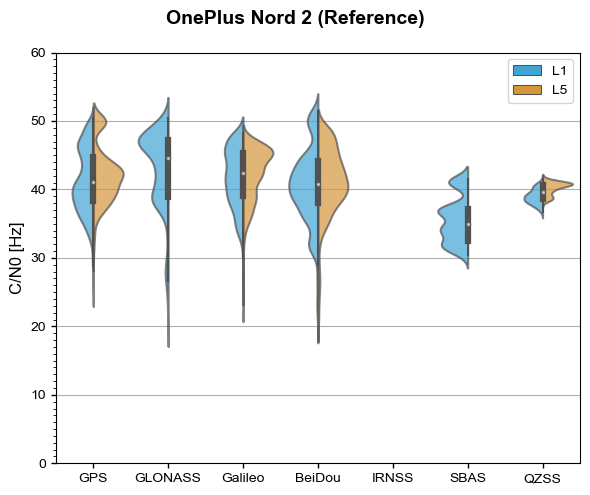

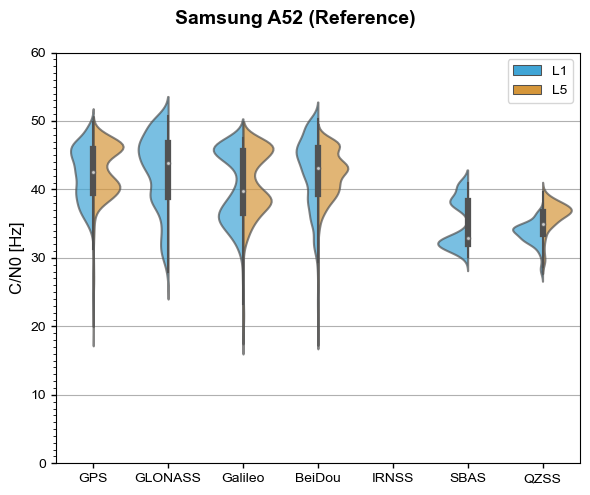

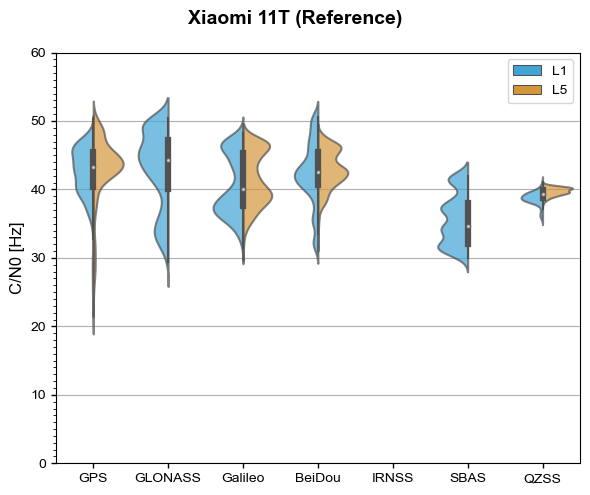

In [16]:
plotStatisticsDataViolin(
    _logs, 
    'snr', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    mode='ref')